In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing, svm, linear_model
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier

data = pd.read_csv("Tweets.csv")

In [3]:
y_raw = data['airline_sentiment']
# labeling data
le = preprocessing.LabelEncoder()
le.fit(y_raw)
le.classes_
y = le.transform(y_raw)

In [4]:
#from nltk.tokenize import word_tokenize
tweet = data['text']

# balanced data

In [24]:
data.shape[0]*0.16140710382513662*0.8

1890.4

In [96]:
from sklearn.utils import shuffle
data = shuffle(data,random_state=42)

index = list()
pos_count = 0
neg_count = 0 
neu_count = 0

for i in range(data.shape[0]):
    if data.iloc[i]["airline_sentiment"] == "positive":
        if pos_count < 1890:
            index.append(data.iloc[i].name)
        else:
            continue 
        pos_count += 1 
    elif data.iloc[i]["airline_sentiment"] == "negative":
        if neg_count < 1890:
            index.append(data.iloc[i].name)
        else:
            continue
        neg_count += 1 
    else:
        if neu_count <1890:
            index.append(data.iloc[i].name)
        else:
            continue
        neu_count += 1 
        
balanced_data = data.filter(index,axis = 0)
    

In [95]:
balanced_data[balanced_data["airline_sentiment"]=="negative"].shape[0]
data.iloc[14000]
len(index)

5670

In [66]:


#data.index.get_loc(data.iloc[5].name)

6421

In [68]:
data
new = data.filter([6421], axis=0)
new

# neutral

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
6421,567869456048865281,neutral,1.0,NaN,NaN,Southwest,NaN,kd35ftw1,NaN,0,@SouthwestAir can you outline the policies for...,NaN,2015-02-17 18:13:23 -0800,NaN,NaN


# END

In [ ]:
# choose the 80% for test  for training data
train_df = df[:11712].reset_index()
test_df = df[11712:].reset_index()

### new process

In [8]:
def sub_remove(df):
    val = re.sub('@', "",df["text"]) 
    val = re.sub(r"http\w+","",val) # remove http://
    return val
#df['remove_1'] = df.apply(sub_remove, axis=1) # remove anything starts with @

In [9]:
# get word counts
count_vect = CountVectorizer()
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
from sklearn.model_selection import StratifiedKFold

# subsamples will be stratified according to y
n = 3

skf = StratifiedKFold(n, shuffle = True)

batches = []
for _, batch in skf.split(X, y):
    print(len(y[batch]))

4881
4880
4879


In [6]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone

class OneVsAllClassifier(BaseEstimator, ClassifierMixin):  
    """
    One-vs-all classifier
    We assume that the classes will be the integers 0,..,(n_classes-1).
    We assume that the estimator provided to the class, after fitting, has a "decision_function" that 
    returns the score for the positive class.
    """
    def __init__(self, estimator, n_classes):      
        """
        Constructed with the number of classes and an estimator (e.g. an
        SVM estimator from sklearn)
        @param estimator : binary base classifier used
        @param n_classes : number of classes
        """
        self.n_classes = n_classes 
        self.estimators = [clone(estimator) for _ in range(n_classes)]
        self.fitted = False

    def fit(self, X, y=None):
        """
        This should fit one classifier for each class.
        self.estimators[i] should be fit on class i vs rest
        @param X: array-like, shape = [n_samples,n_features], input data
        @param y: array-like, shape = [n_samples,] class labels
        @return returns self
        """
        #Your code goes here
        # design a binary label of y for each estimator
        for i in range(self.n_classes):
            y_bi = np.copy(y)
            y_bi[y_bi!=i]=-1
            self.estimators[i].fit(X,y_bi)
        self.fitted = True  
        return self   

    def decision_function(self, X):
        """
        Returns the score of each input for each class. Assumes
        that the given estimator also implements the decision_function method (which sklearn SVMs do), 
        and that fit has been called.
        @param X : array-like, shape = [n_samples, n_features] input data
        @return array-like, shape = [n_samples, n_classes]
        """
        if not self.fitted:
            raise RuntimeError("You must train classifer before predicting data.")

        if not hasattr(self.estimators[0], "decision_function"):
            raise AttributeError(
                "Base estimator doesn't have a decision_function attribute.")
        
        #Replace the following return statement with your code
        score = np.zeros([X.shape[0],self.n_classes])
        for i in range(self.n_classes):
            score[:,i] = self.estimators[i].decision_function(X)
        return score
    
    def predict(self, X):
        """
        Predict the class with the highest score.
        @param X: array-like, shape = [n_samples,n_features] input data
        @returns array-like, shape = [n_samples,] the predicted classes for each input
        """
        #Replace the following return statement with your code
        score = self.decision_function(X)
        prediction = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            prediction[i] = np.argmax(score[i])
        return prediction

 

In [16]:
#Here we test the OneVsAllClassifier
svm_estimator = svm.LinearSVC(loss='hinge', fit_intercept=False, C=0.2)
clf_onevsall = OneVsAllClassifier(svm_estimator, n_classes=3)
clf_onevsall.fit(X_train,y_train)

loss = []
for i in range(len(y_valid)):
    loss.append(int(y_valid[i]!=int(clf_onevsall.predict(X_valid)[i])))
print(1-np.sum(loss)/len(y_valid))
    
from sklearn import metrics
metrics.confusion_matrix(y_valid, clf_onevsall.predict(X_valid))

0.80806010929


array([[1722,  120,   47],
       [ 198,  320,   62],
       [  83,   52,  324]])

In [34]:
clf = svm.SVC()
clf.fit(X_train,y_train)

loss = []
for i in range(len(y_valid)):
    loss.append(int(y_valid[i]!=int(clf.predict(X_valid)[i])))
print(1-np.sum(loss)/len(y_valid))

metrics.confusion_matrix(y_valid, clf.predict(X_valid))

KeyboardInterrupt: 

In [27]:
ovo = OneVsOneClassifier(svm.LinearSVC(C=0.02))
ovo.fit(X_train, y_train)

loss = []
for i in range(len(y_valid)):
    loss.append(int(y_valid[i]!=int(ovo.predict(X_valid)[i])))
print(1-np.sum(loss)/len(y_valid))

metrics.confusion_matrix(y_valid, ovo.predict(X_valid))

0.802254098361


array([[1714,  133,   42],
       [ 201,  335,   44],
       [  97,   62,  300]])

In [10]:
# gradient boosting
clf_gbm = GradientBoostingClassifier()
clf_gbm.fit(X_train,y_train)

loss = []
for i in range(len(y_valid)):
    loss.append(int(y_valid[i]!=int(clf_gbm.predict(X_valid.toarray())[i])))
print(1-np.sum(loss)/len(y_valid))

metrics.confusion_matrix(y_valid, clf_gbm.predict(X_valid.toarray()))

0.75956284153


array([[1797,   43,   49],
       [ 376,  168,   36],
       [ 153,   47,  259]])

In [38]:
# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(X_train,y_train)

loss = []
for i in range(len(y_valid)):
    loss.append(int(y_valid[i]!=int(clf_rfc.predict(X_valid)[i])))
print(1-np.sum(loss)/len(y_valid))

metrics.confusion_matrix(y_valid, clf_rfc.predict(X_valid))

0.775273224044


array([[1818,   57,   14],
       [ 318,  233,   29],
       [ 189,   51,  219]])

In [35]:
clf=linear_model.LogisticRegression(C=0.4)
clf.fit(X_train,y_train)

loss = []
for i in range(len(y_valid)):
    loss.append(int(y_valid[i]!=int(clf.predict(X_valid)[i])))
print(1-np.sum(loss)/len(y_valid))

metrics.confusion_matrix(y_valid, clf.predict(X_valid))

0.806352459016


array([[1722,  127,   40],
       [ 201,  329,   50],
       [  94,   55,  310]])

In [103]:
tweet_train, tweet_valid, ty_train, ty_valid = train_test_split(tweet, y, test_size=0.2, random_state=42)

In [104]:
ty_valid.shape

(2928,)

In [105]:
vectorizer = TfidfVectorizer(min_df=5,max_df = 0.8,sublinear_tf=True,use_idf=True)
tX_train = vectorizer.fit_transform(tweet_train)
tX_valid = vectorizer.transform(tweet_valid)

In [42]:
svm_estimator = svm.LinearSVC(loss='hinge', fit_intercept=False, C=0.85)
clf_onevsall = OneVsAllClassifier(svm_estimator, n_classes=3)
clf_onevsall.fit(tX_train,ty_train)

loss = []
for i in range(len(ty_valid)):
    loss.append(int(ty_valid[i]!=int(clf_onevsall.predict(tX_valid)[i])))
print(1-np.sum(loss)/len(ty_valid))
    
metrics.confusion_matrix(ty_valid, clf_onevsall.predict(tX_valid))

0.812841530055


array([[1766,   84,   39],
       [ 231,  300,   49],
       [  98,   47,  314]])

In [35]:
clf = svm.SVC(C=100,kernel='linear')
clf.fit(tX_train,ty_train)

loss = []
for i in range(len(ty_valid)):
    loss.append(int(ty_valid[i]!=int(clf.predict(tX_valid)[i])))
print(1-np.sum(loss)/len(ty_valid))

metrics.confusion_matrix(ty_valid, clf.predict(tX_valid))

KeyboardInterrupt: 

In [48]:
ovo = OneVsOneClassifier(svm.LinearSVC(C=0.25))
ovo.fit(tX_train, ty_train)

loss = []
for i in range(len(ty_valid)):
    loss.append(int(ty_valid[i]!=int(ovo.predict(tX_valid)[i])))
print(1-np.sum(loss)/len(ty_valid))

metrics.confusion_matrix(ty_valid, ovo.predict(tX_valid))

0.811133879781


array([[1756,  100,   33],
       [ 216,  321,   43],
       [ 102,   59,  298]])

In [58]:
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(tX_train,ty_train)

loss = []
for i in range(len(ty_valid)):
    loss.append(int(ty_valid[i]!=int(clf_gbm.predict(tX_valid.toarray())[i])))
print(1-np.sum(loss)/len(ty_valid))

metrics.confusion_matrix(ty_valid, clf_gbm.predict(tX_valid.toarray()))

0.782103825137


array([[1740,   98,   51],
       [ 267,  273,   40],
       [ 121,   61,  277]])

In [56]:
clf_rfc = RandomForestClassifier(n_estimators=100,oob_score=True,random_state = 42)
clf_rfc.fit(tX_train,ty_train)

loss = []
for i in range(len(ty_valid)):
    loss.append(int(ty_valid[i]!=int(clf_rfc.predict(tX_valid)[i])))
print(1-np.sum(loss)/len(ty_valid))

metrics.confusion_matrix(ty_valid, clf_rfc.predict(tX_valid))

TypeError: __init__() got an unexpected keyword argument 'loss'

In [71]:
from sklearn.metrics import roc_auc_score
clf_rfc = RandomForestClassifier(n_estimators=500,oob_score=True,random_state = 42)
clf_rfc.fit(tX_train,ty_train)
clf_rfc.oob_score_

0.75529371584699456

In [72]:
loss = []
for i in range(len(ty_valid)):
    loss.append(int(ty_valid[i]!=int(clf_rfc.predict(tX_valid)[i])))
print(1-np.sum(loss)/len(ty_valid))

metrics.confusion_matrix(ty_valid, clf_rfc.predict(tX_valid))

0.772540983607


array([[1802,   62,   25],
       [ 312,  232,   36],
       [ 178,   53,  228]])

In [55]:
clf=linear_model.LogisticRegression(C=3.5)
clf.fit(tX_train,ty_train)

loss = []
for i in range(len(ty_valid)):
    loss.append(int(ty_valid[i]!=int(clf.predict(tX_valid)[i])))
print(1-np.sum(loss)/len(ty_valid))

metrics.confusion_matrix(ty_valid, clf.predict(tX_valid))

0.813866120219


array([[1758,   97,   34],
       [ 218,  313,   49],
       [  96,   51,  312]])

In [ ]:
def zeroOne(y,a) :
    '''
    Computes the zero-one loss.
    @param y: output class
    @param a: predicted class
    @return 1 if different, 0 if same
    '''
    return int(y != a)

def featureMap(X,y,num_classes) :
    '''
    Computes the class-sensitive features.
    @param X: array-like, shape = [n_samples,n_inFeatures] or [n_inFeatures,], input features for input data
    @param y: a target class (in range 0,..,num_classes-1)
    @return array-like, shape = [n_samples,n_outFeatures], the class sensitive features for class y
    '''
    #The following line handles X being a 1d-array or a 2d-array
    num_samples, num_inFeatures = (1,X.shape[0]) if len(X.shape) == 1 else (X.shape[0],X.shape[1])
    
    psi = np.zeros([num_samples, num_inFeatures * num_classes])
    for i in range(num_samples):
        for j in range(num_inFeatures):
            psi[i,y * num_inFeatures + j] = X[i,j]
    return psi



class MulticlassSVM(BaseEstimator, ClassifierMixin):
    '''
    Implements a Multiclass SVM estimator.
    '''
    def __init__(self, num_outFeatures, lam=1.0, num_classes=3, Delta=zeroOne, Psi=featureMap):       
        '''
        Creates a MulticlassSVM estimator.
        @param num_outFeatures: number of class-sensitive features produced by Psi
        @param lam: l2 regularization parameter
        @param num_classes: number of classes (assumed numbered 0,..,num_classes-1)
        @param Delta: class-sensitive loss function taking two arguments (i.e., target margin)
        @param Psi: class-sensitive feature map taking two arguments
        '''
        self.num_outFeatures = num_outFeatures
        self.lam = lam
        self.num_classes = num_classes
        self.Delta = Delta
        self.Psi = lambda X,y : Psi(X,y,num_classes)
        self.fitted = False
    
    def subgradient(self,X,y, eta = 0.1, T = 10000):
        '''
        Computes the subgradient at a given data point x,y
        @param x: sample input
        @param y: sample class
        @param w: parameter vector
        @return returns subgradient vector at given x,y,w
        '''
        
        num_samples = X.shape[0]
        
        #np.random.seed(2)
        random_ind = np.array(range(num_samples))
        np.random.shuffle(random_ind)
        t = 1
        w = np.zeros(self.num_outFeatures)
        while t <= T:
            for ind in random_ind:
                y_max = np.zeros(self.num_classes)
                for y_i in range(self.num_classes):
                    #ind = np.where(X==x)[0][0]
                    y_max[y_i] = self.Delta(y[ind],y_i) + np.dot(self.Psi(X,y_i)[ind] - self.Psi(X,y[ind])[ind],w)
                y_hat = np.argmax(y_max)
        
                subgrad = 2 * self.lam * w + (self.Psi(X,y_hat)[ind] - self.Psi(X,y[ind])[ind])
                w = w - subgrad * eta
                t = t + 1
        return w
        
    def fit(self,X,y,eta=0.1,T=10000):
        '''
        Fits multiclass SVM
        @param X: array-like, shape = [num_samples,num_inFeatures], input data
        @param y: array-like, shape = [num_samples,], input classes
        @param eta: learning rate for SGD
        @param T: maximum number of iterations
        @return returns self
        '''
        self.coef_ = self.subgradient(X,y,eta = 0.1, T = 100)
        self.fitted = True
        return self
    
    def decision_function(self, X):
        '''
        Returns the score on each input for each class. Assumes
        that fit has been called.
        @param X : array-like, shape = [n_samples, n_inFeatures]
        @return array-like, shape = [n_samples, n_classes] giving scores for each sample,class pairing
        '''
        if not self.fitted:
            raise RuntimeError("You must train classifer before predicting data.")

        score = np.zeros([X.shape[0],self.num_classes])
        for j in range(self.num_classes):
            score[:,j] = np.dot(self.Psi(X,j),self.coef_)
        return score
            
    def predict(self, X):
        '''
        Predict the class with the highest score.
        @param X: array-like, shape = [n_samples, n_inFeatures], input data to predict
        @return array-like, shape = [n_samples,], class labels predicted for each data point
        '''

        score = self.decision_function(X)
        prediction = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            prediction[i] = np.argmax(score[i])
        return prediction

In [ ]:
#the following code tests the MulticlassSVM and sgd
#will fail if MulticlassSVM is not implemented yet
est = MulticlassSVM(45153,lam=1)
est.fit(X_train,y_train,eta=0.01) # choose a smaller eta of 0.01
print("w:")
print(est.coef_)

from sklearn import metrics
metrics.confusion_matrix(y_test, est.predict(X_test))

In [73]:
# get word counts
# bi-grams
count_vect = CountVectorizer(ngram_range=(1,2))
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [87]:
#Here we test the OneVsAllClassifier
svm_estimator = svm.LinearSVC(loss='hinge', fit_intercept=False, C=0.05)
clf_onevsall = OneVsAllClassifier(svm_estimator, n_classes=3)
clf_onevsall.fit(X_train,y_train)

loss = []
for i in range(len(y_valid)):
    loss.append(int(y_valid[i]!=int(clf_onevsall.predict(X_valid)[i])))
print(1-np.sum(loss)/len(y_valid))
    
from sklearn import metrics
metrics.confusion_matrix(y_valid, clf_onevsall.predict(X_valid))

0.811133879781


array([[1722,  121,   46],
       [ 190,  336,   54],
       [  85,   57,  317]])

In [ ]:
ovo = OneVsOneClassifier(svm.LinearSVC(C=0.025))
ovo.fit(X_train, y_train)

loss = []
for i in range(len(y_valid)):
    loss.append(int(y_valid[i]!=int(ovo.predict(X_valid)[i])))
print(1-np.sum(loss)/len(y_valid))

metrics.confusion_matrix(y_valid, ovo.predict(X_valid))

0.804644808743


array([[1692,  152,   45],
       [ 173,  358,   49],
       [  85,   68,  306]])

In [ ]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(X_train,y_train)

loss = []
for i in range(len(y_valid)):
    loss.append(int(y_valid[i]!=int(clf_gbm.predict(X_valid.toarray())[i])))
print(1-np.sum(loss)/len(y_valid))

metrics.confusion_matrix(y_valid, clf_gbm.predict(X_valid.toarray()))

In [38]:
# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(X_train,y_train)

loss = []
for i in range(len(y_valid)):
    loss.append(int(y_valid[i]!=int(clf_rfc.predict(X_valid)[i])))
print(1-np.sum(loss)/len(y_valid))

metrics.confusion_matrix(y_valid, clf_rfc.predict(X_valid))

0.775273224044


array([[1818,   57,   14],
       [ 318,  233,   29],
       [ 189,   51,  219]])

In [71]:
clf=linear_model.LogisticRegression(C=0.5)
clf.fit(X_train,y_train)

loss = []
for i in range(len(y_valid)):
    loss.append(int(y_valid[i]!=int(clf.predict(X_valid)[i])))
print(1-np.sum(loss)/len(y_valid))

metrics.confusion_matrix(y_valid, clf.predict(X_valid))

0.811133879781


array([[1725,  125,   39],
       [ 182,  344,   54],
       [  93,   60,  306]])

In [1]:
# get word counts
# 3-grams
count_vect = CountVectorizer(ngram_range=(1,3))
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

NameError: name 'CountVectorizer' is not defined

In [88]:
clf=linear_model.LogisticRegression(C=10)
clf.fit(X_train,y_train)

loss = []
for i in range(len(y_valid)):
    loss.append(int(y_valid[i]!=int(clf.predict(X_valid)[i])))
print(1-np.sum(loss)/len(y_valid))

metrics.confusion_matrix(y_valid, clf.predict(X_valid))

0.813524590164


array([[1717,  130,   42],
       [ 173,  355,   52],
       [  87,   62,  310]])

In [120]:
# get word counts
# 4-grams
count_vect = CountVectorizer(ngram_range=(1,4))
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [133]:
clf=linear_model.LogisticRegression(C=1.5)
clf.fit(X_train,y_train)

loss = []
for i in range(len(y_valid)):
    loss.append(int(y_valid[i]!=int(clf.predict(X_valid)[i])))
print(1-np.sum(loss)/len(y_valid))

metrics.confusion_matrix(y_valid, clf.predict(X_valid))

0.811816939891


array([[1738,  113,   38],
       [ 192,  342,   46],
       [  98,   64,  297]])

In [92]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha=1.0)
clf.fit(X_train, y_train)

loss = []
for i in range(len(y_valid)):
    loss.append(int(y_valid[i]!=int(clf.predict(X_valid)[i])))
print(1-np.sum(loss)/len(y_valid))

metrics.confusion_matrix(y_valid, clf.predict(X_valid))

0.74043715847


array([[1871,   13,    5],
       [ 428,  140,   12],
       [ 282,   20,  157]])

In [103]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha=0.2)
clf.fit(tX_train, ty_train)

loss = []
for i in range(len(ty_valid)):
    loss.append(int(ty_valid[i]!=int(clf.predict(tX_valid)[i])))
print(1-np.sum(loss)/len(ty_valid))

metrics.confusion_matrix(ty_valid, clf.predict(tX_valid))

0.775273224044


array([[1829,   52,    8],
       [ 345,  211,   24],
       [ 187,   42,  230]])

In [107]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(tX_train.toarray(), ty_train)

loss = []
for i in range(len(ty_valid)):
    loss.append(int(ty_valid[i]!=int(clf_gbm.predict(tX_valid.toarray())[i])))
print(1-np.sum(loss)/len(ty_valid))

metrics.confusion_matrix(ty_valid, clf_gbm.predict(tX_valid.toarray()))

0.75956284153


array([[1789,   61,   39],
       [ 359,  187,   34],
       [ 155,   56,  248]])

In [106]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB(alpha=1.0)
clf.fit(tX_train, ty_train)

loss = []
for i in range(len(ty_valid)):
    loss.append(int(ty_valid[i]!=int(clf.predict(tX_valid)[i])))
print(1-np.sum(loss)/len(ty_valid))

metrics.confusion_matrix(ty_valid, clf.predict(tX_valid))
clf.predict(tX_valid)

0.791666666667


NameError: name 'metrics' is not defined

In [108]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB(alpha=1.0)
clf.fit(tX_train, ty_train)

loss = []
for i in range(len(ty_valid)):
    loss.append(int(ty_valid[i]!=int(clf.predict(tX_valid)[i])))
print(1-np.sum(loss)/len(ty_valid))

metrics.confusion_matrix(ty_valid, clf.predict(tX_valid))

0.791666666667


NameError: name 'metrics' is not defined

In [97]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def plotUnivaiateROC(preds,truth,label_string):
    fpr,tpr,thresholds = roc_curve(truth,preds,pos_label = 1)
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr,tpr, label = label_string + ' (AUC = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0]) 
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")
    
fig = plt.figure(figsize = (6, 6))
ax = plt.subplot(111)

plotUnivaiateROC(clf.predict(tX_valid),ty_valid,"NaiveBayes")

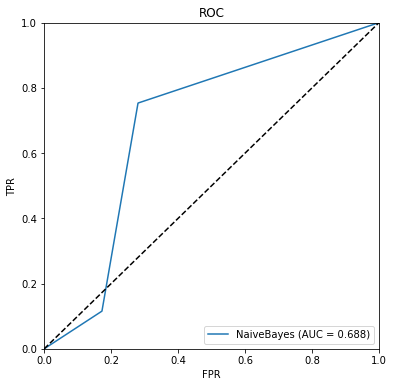